In [0]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkContext
from pyspark.sql import SparkSession

sc=SparkContext.getOrCreate()
spark=SparkSession.builder.appName("Spark DataFrames").getOrCreate()
df=spark.read.table("hive_metastore.default.credit_card")

# Display the first few rows
df.head()

Row(RowNumber=1, CustomerId=15634602, Surname='Hargrave', CreditScore=619, Geography='France', Gender='Female', Age=42, Tenure=2, Balance=0.0, NumOfProducts=1, IsActiveMember=1, EstimatedSalary=101348.88, Exited=1)

In [0]:
from pyspark.sql.functions import col, isnull, count, when

# Check for missing values in each column
missing_values = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
missing_values.show()


+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+--------------+---------------+------+
|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+--------------+---------------+------+
|        0|         0|      0|          0|        0|     0|  0|     0|      0|            0|             0|              0|     0|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+--------------+---------------+------+



In [0]:
# Basic statistics for numerical columns
df.describe().show()


+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-----------------+-------------------+
|summary|         RowNumber|       CustomerId|Surname|      CreditScore|Geography|Gender|               Age|            Tenure|          Balance|     NumOfProducts|     IsActiveMember|  EstimatedSalary|             Exited|
+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-----------------+-------------------+
|  count|             10000|            10000|  10000|            10000|    10000| 10000|             10000|             10000|            10000|             10000|              10000|            10000|              10000|
|   mean|            5000.5|  1.56909405694E7|   NULL|         650.5288|     NULL|  NULL|           38.9218|

In [0]:
# Fill missing values with median (numerical columns only)
numerical_columns = [col_name for col_name, dtype in df.dtypes if dtype in ('int', 'double')]

for column in numerical_columns:
    median_value = df.approxQuantile(column, [0.5], 0.01)[0]
    df = df.fillna({column: median_value})

# Show updated DataFrame
df.show(5)


+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|             0|       93826.63|     0|
|        5|  15737888|Mitchell|        850|    Spain|Female| 4

In [0]:
# Drop duplicate rows
df = df.dropDuplicates()

# Show updated DataFrame
df.show(5)


+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+--------------+---------------+------+
|       30|  15656300|Lucciano|        411|   France|  Male| 29|     0| 59697.17|            2|             1|       53483.21|     0|
|      220|  15774854|  Fuller|        592|   France|  Male| 54|     8|      0.0|            1|             1|       28737.71|     1|
|      423|  15674551|   Fitch|        535|  Germany|  Male| 40|     7| 111756.5|            1|             0|        8128.32|     1|
|      443|  15672145|   Swift|        534|   France|Female| 34|     7|121551.58|            2|             1|        70179.0|     0|
|      806|  15756026|  Hooper|        790|    Spain|Female| 4

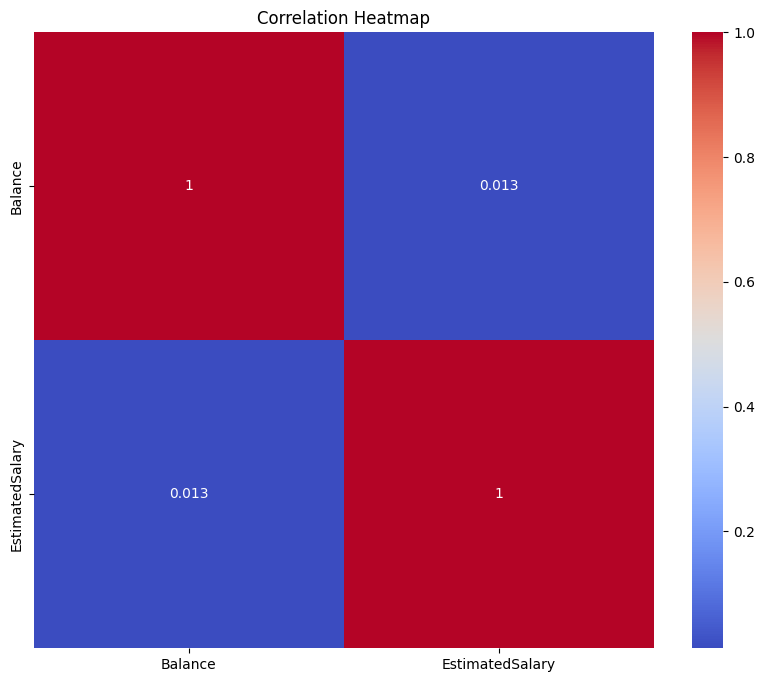

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation heatmap for numerical columns
numerical_columns = [col_name for col_name, dtype in df.dtypes if dtype in ('int', 'double')]
pandas_df = df.select(numerical_columns).toPandas()  # Convert to Pandas for visualization
correlation_matrix = pandas_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


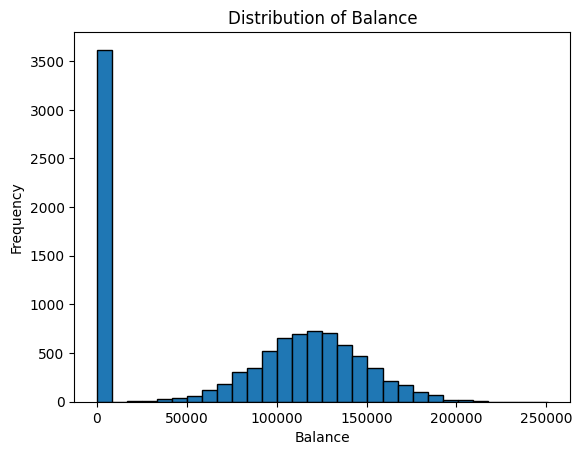

In [0]:
# Distribution plot for one column (replace with your column name)
column_to_plot = numerical_columns[0]  # Replace with your choice

pandas_df[column_to_plot].plot(kind='hist', bins=30, edgecolor='black')
plt.title(f"Distribution of {column_to_plot}")
plt.xlabel(column_to_plot)
plt.ylabel("Frequency")
plt.show()


In [0]:
# Value counts for categorical columns
categorical_columns = [col_name for col_name, dtype in df.dtypes if dtype == 'string']

for column in categorical_columns:
    df.groupBy(column).count().show()


+------------+-----+
|     Surname|count|
+------------+-----+
|      Clunie|    1|
|      Piccio|   13|
|      Lavrov|    2|
|   Bezrukova|    2|
|  Kambinachi|    5|
|      Ohearn|    1|
|      Avdeev|    1|
|     Palermo|   12|
|    Sokolova|    2|
|      Azarov|    1|
|       Tyler|    4|
|     Wofford|    1|
|      Duigan|    2|
|    Rawlings|    1|
|       Rubeo|    1|
| Baryshnikov|    2|
|    Lazareva|    3|
|      Arbour|    1|
|        Saad|    1|
|Rapuluchukwu|    1|
+------------+-----+
only showing top 20 rows

+---------+-----+
|Geography|count|
+---------+-----+
|  Germany| 2509|
|   France| 5014|
|    Spain| 2477|
+---------+-----+

+------+-----+
|Gender|count|
+------+-----+
|Female| 4543|
|  Male| 5457|
+------+-----+



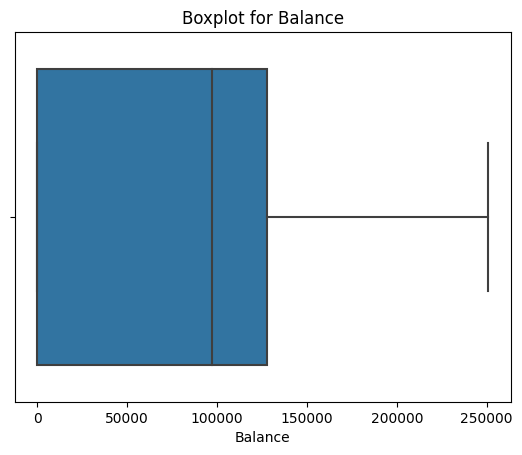

In [0]:
# Boxplot for outlier detection (example for a numerical column)
sns.boxplot(x=pandas_df[column_to_plot])
plt.title(f"Boxplot for {column_to_plot}")
plt.show()
